### MCSs tracking records from 1985-2008
- A long‐term tropical mesoscale convective systems dataset based on a novel objective automatic tracking algorithm (Huang et al., 2018)
- The MCSs records are detected from the BT threshold of 233 K, the area coverage threshold of 5000 square kilometers, and the overlapping threshold of 15%

In [2]:
import sys
import os
import xarray as xr
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import dask.array as da

from datetime import datetime, timedelta
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import warnings
import psutil
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib import patches
from matplotlib import cm

In [3]:
import scipy.io as spio

In [4]:
os.chdir('/w2-data/willytsai/MCS_dataset')
files = glob('*mat')
mat = spio.loadmat(files[0], squeeze_me=True)

In [5]:
def readMatfile(file_name):
    
    files = glob('*mat') # get file name
    mat = spio.loadmat(files[0], squeeze_me=True)
    data = mat['MCS_record'] # structure containing an array

    # set lists
    idx = [];frames = [];glat = [];glon = [];wlat = []
    wlon = [];size = [];ave_temp = [];min_temp = [];list_time = []
    list_speed = [];list_direct = [];list_grid = [ ];list_deg = []
    list_temp = [];eccen = [];speed = [];direct = []

    for n in range(len(data)):
        idx.append(data[n][0])
        frames.append(data[n][1])
        glat.append(data[n][2])
        glon.append(data[n][3])
        wlat.append(data[n][4])
        wlon.append(data[n][5])
        size.append(data[n][6])
        ave_temp.append(data[n][7])
        min_temp.append(data[n][8])
        list_time.append(data[n][9])
        list_speed.append(data[n][10])
        list_direct.append(data[n][11])
        list_grid.append(data[n][12])
        list_deg.append(data[n][13])
        list_temp.append(data[n][14])
        eccen.append(data[n][15])
        speed.append(data[n][16])
        direct.append(data[n][17])

        data_dict = dict(idx=idx,frames=frames,glat=glat,glon=glon,wlat=wlat,wlon=wlon
                ,size=size,ave_temp=ave_temp,min_temp=min_temp,list_time=list_time,list_speed=list_speed
                ,list_direct=list_direct,list_grid=list_grid,list_deg=list_deg,list_temp=list_temp
                ,eccen=eccen,speed=speed,direct=direct)
        
    return data_dict

In [6]:
# read summarized txt file
os.chdir('./MCS_record_1985_02_2008-11/')

In [7]:
# taking only the nearest 10 years MCS cases from 1999-2008
years = np.arange(1999,2009)
n = 1
for yr in years:
    tmp = sorted(glob('*'+str(yr)+'*.txt'))
    if n == 1:
        files = tmp; n+=1
    else:
        for i in range(len(tmp)):
            files.append(tmp[i])

In [8]:
files

['MCS_record_1999-01.txt',
 'MCS_record_1999-02.txt',
 'MCS_record_1999-03.txt',
 'MCS_record_1999-04.txt',
 'MCS_record_1999-05.txt',
 'MCS_record_1999-06.txt',
 'MCS_record_1999-07.txt',
 'MCS_record_1999-08.txt',
 'MCS_record_1999-09.txt',
 'MCS_record_1999-10.txt',
 'MCS_record_1999-11.txt',
 'MCS_record_1999-12.txt',
 'MCS_record_2000-01.txt',
 'MCS_record_2000-02.txt',
 'MCS_record_2000-03.txt',
 'MCS_record_2000-04.txt',
 'MCS_record_2000-05.txt',
 'MCS_record_2000-06.txt',
 'MCS_record_2000-07.txt',
 'MCS_record_2000-08.txt',
 'MCS_record_2000-09.txt',
 'MCS_record_2000-10.txt',
 'MCS_record_2000-11.txt',
 'MCS_record_2000-12.txt',
 'MCS_record_2001-01.txt',
 'MCS_record_2001-02.txt',
 'MCS_record_2001-03.txt',
 'MCS_record_2001-04.txt',
 'MCS_record_2001-05.txt',
 'MCS_record_2001-06.txt',
 'MCS_record_2001-07.txt',
 'MCS_record_2001-08.txt',
 'MCS_record_2001-09.txt',
 'MCS_record_2001-10.txt',
 'MCS_record_2001-11.txt',
 'MCS_record_2001-12.txt',
 'MCS_record_2002-01.txt',
 

In [9]:
%%time
labels = ['ID','lifetime','glat','glon','wlat','wlon','size','eccentricity','BTavg'
,'BTmin','speed','direction']

num_tot = 0

lat_bin = np.linspace(-30,30,61)
lon_bin = np.linspace(0,360,361)

freq_map = np.zeros((len(lon_bin)-1,len(lat_bin)-1))

for n in range(len(files)):
    data = np.loadtxt(files[n],skiprows=1,usecols=(0,1,2,3,4,5,6,7,8,9,11,12)) # skip time
    
    lat_array = data[:,2] # glat
    lon_array = data[:,3] # glon
        
    for i in range(len(lon_bin)-1):
        for j in range(len(lat_bin)-1):
            idx = np.where(np.logical_and(lon_array>=lon_bin[i], lon_array<lon_bin[i+1]))[0]
            idy = np.where(np.logical_and(lat_array>=lat_bin[j], lat_array<lat_bin[j+1]))[0]

            if len(np.intersect1d(idx,idy)) > 0:
                freq_map[i,j] += len(np.intersect1d(idx,idy))

CPU times: user 15min 27s, sys: 841 ms, total: 15min 28s
Wall time: 15min 30s


#### global map for MCSs frequency 

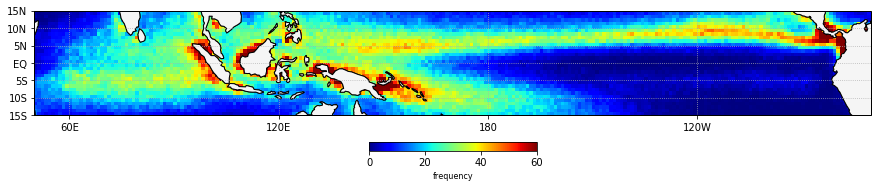

In [17]:
fig = plt.figure(figsize=(15,5))

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax.coastlines()
ax.add_feature(cfeat.LAND,zorder=1,edgecolor='k',facecolor='whitesmoke') # maskout LAND

cf = plt.pcolormesh(lon_bin[:-1],lat_bin[:-1],freq_map.T/10,transform=ccrs.PlateCarree()
                    ,cmap='jet',vmin=0,vmax=60)
#plt.contour(lon_bin[:-1],lat[:-1],freq_map.T,transform=ccrs.PlateCarree(),levels=[5],colors=['skyblue'],
#           linewidths=1,alpha=1)

ax.set_yticks([-20,-15,-10,-5,0,5,10,15,20])
ax.set_yticklabels(['20S','15S','10S','5S','EQ','5N','10N','15N','20N'])
ax.set_xticks([-180,-120,-60,-0,60,120,180])
ax.set_xticklabels(['0','60E','120E','180','120W','60W','0'])
ax.set_ylim([-15,15]);ax.grid(linestyle=':')
ax.set_xlim([-130,110])
cbar = plt.colorbar(cf,shrink=0.2,pad=0.1,orientation='horizontal')
cbar.set_label('frequency',fontsize=8)

In [11]:
#np.save('MCS_freqmap_1999_2008.npy',freq_map)